In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
import seaborn as sns
import itertools

In [2]:
boston = load_data('Boston')
X = boston.drop('crim', axis=1)
y = boston['crim']
X_train = X.copy()
y_train = y.copy()

In [7]:
scaler = StandardScaler()
ridge = RidgeCV()
gamma = GammaRegressor(alpha = 0.44, max_iter=100000)
tweedie = TweedieRegressor(alpha = 0.44, max_iter=100000)
lasso = ElasticNetCV(l1_ratio=1, max_iter=100000,selection='random')
ols = LinearRegression()
elasticnet = ElasticNetCV(max_iter=100000,selection='random')
models = {'ridge': ridge, 'lasso' : lasso, 'ols' : ols,
          'elasticnet' : elasticnet, 'gamma' : gamma, 'tweedie' : tweedie}

In [8]:
%%capture
results = {}
for name, model in models.items():
    pipe = make_pipeline(scaler, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean();
print("Various Linear model Cross_Val MSE:")
# No model clearly better

In [9]:
results

{'ridge': 2.5120424286615477,
 'lasso': 2.279607669697472,
 'ols': 2.517618656918609,
 'elasticnet': 2.385602473958982,
 'gamma': 1.0185437923309526,
 'tweedie': 2.194919156021363}

In [10]:
# Adding Interaction features
results = {}
interact = PolynomialFeatures(interaction_only=True)
for name, model in models.items():
    pipe = make_pipeline(scaler, interact, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model with Interactions Cross_Val MSE:")
results

Various Linear model with Interactions Cross_Val MSE:


{'ridge': 2.3860074519682897,
 'lasso': 1.594673512167999,
 'ols': 3.060294039502091,
 'elasticnet': 1.750203066383871,
 'gamma': 1.0469107604104388,
 'tweedie': 1.9837763846453165}

<Axes: ylabel='crim'>

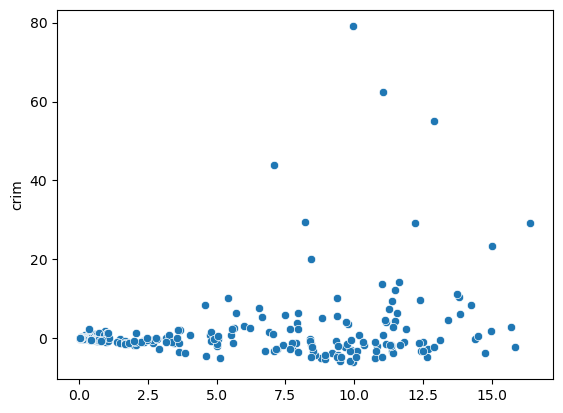

In [11]:
test = make_pipeline(scaler, gamma)
test.fit(X_train, y_train)
residuals = (y_train - test.predict(X_train))
sns.scatterplot(x=test.predict(X_train), y=residuals)

In [12]:
### Lasso for Variable Selection
pipe = make_pipeline(scaler,interact, lasso)
pipe.fit(X_train, y_train)
print(f' Lasso selected {(pipe._final_estimator.coef_ != 0).sum()} predictors over the total {pipe._final_estimator.coef_.shape[0]} generated by the interactions')

 Lasso selected 13 predictors over the total 79 generated by the interactions


In [13]:
# Adding Interaction and polynomial features
results = {}
interact = PolynomialFeatures(degree=2)
for name, model in models.items():
    pipe = make_pipeline(scaler, interact, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model with Interactions Cross_Val MSE:")
results

Various Linear model with Interactions Cross_Val MSE:


{'ridge': 2.436743311398722,
 'lasso': 1.9366779994054575,
 'ols': 3.072188029296875,
 'elasticnet': 1.9460834137765424,
 'gamma': 1.115654676509966,
 'tweedie': 2.03127632248417}

In [14]:
### Lasso for Variable Selection
pipe = make_pipeline(scaler,interact, lasso)
pipe.fit(X_train, y_train)
print(f' Lasso selected {(pipe._final_estimator.coef_ != 0).sum()} predictors over the total {pipe._final_estimator.coef_.shape[0]} generated by the interactions')

 Lasso selected 10 predictors over the total 91 generated by the interactions


In [15]:
### Let's try perdicting the log of the target

results = {}
for name, model in models.items():
    intermediary_pipe = make_pipeline(scaler, model)
    pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")
results

Various Linear model to predict log of crim Cross_Val MSE:


{'ridge': 1.193633761185287,
 'lasso': 1.1840247629915428,
 'ols': 1.199729319379958,
 'elasticnet': 1.1866486732474089,
 'gamma': 0.9639559227763753,
 'tweedie': 1.007873570080537}

<Axes: ylabel='crim'>

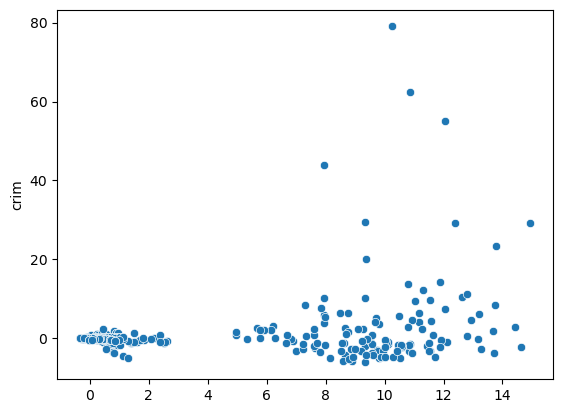

In [16]:
intermediary_pipe = make_pipeline(scaler, ridge)
pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
pipe.fit(X_train, y_train)
residuals = (y_train - test.predict(X_train))
sns.scatterplot(x=pipe.predict(X_train), y=residuals)

In [17]:
%%capture
### Let's try perdicting the log of the target with degree 2

results = {}
interact = PolynomialFeatures(degree=2)
for name, model in models.items():
    intermediary_pipe = make_pipeline(scaler,interact, model)
    pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [18]:
results

{'ridge': 1.0501655026704975,
 'lasso': 0.917755603774039,
 'ols': nan,
 'elasticnet': 0.9062934993584701,
 'gamma': 0.9194334797490509,
 'tweedie': 0.9807921478272528}

In [19]:
%%capture
### Let's try perdicting the log of the target with intera

results = {}
interact = PolynomialFeatures(degree=2, interaction_only=True)
for name, model in models.items():
    intermediary_pipe = make_pipeline(scaler,interact, model)
    pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [20]:
results

{'ridge': 1.0287686777681877,
 'lasso': 0.8181071345435124,
 'ols': nan,
 'elasticnet': 0.8313167860404175,
 'gamma': 0.9463779011767777,
 'tweedie': 1.0001449409304173}

In [21]:
%%capture
### Let's use PCA to reduce the dimension

results = {}
pca = PCA(n_components = 'mle')
for name, model in models.items(): 
    pipe = make_pipeline(scaler, pca, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [22]:
results

{'ridge': 2.524604485003452,
 'lasso': 2.5504364316298607,
 'ols': 2.5816651274570637,
 'elasticnet': 2.488234533388666,
 'gamma': 1.0213394494050063,
 'tweedie': 2.1658221708953773}

In [23]:
# Let's look at all the PCA component reductions

results = []
for i in range(1, 13):
    pca = PCA(n_components = i)
    pipe = make_pipeline(scaler, pca, ols)
    result = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
    results.append(result)

<Axes: >

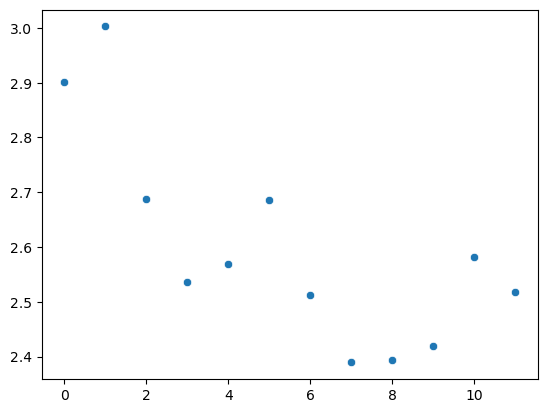

In [24]:
sns.scatterplot(results)

In [25]:
# Let's look at all the PCA component reductions but with interactions

results = []
max_predictors = PolynomialFeatures(degree=2).fit_transform(X_train).shape[1]
interact = PolynomialFeatures(degree=2)
for i in range(1, max_predictors):
    pca = PCA(n_components = i)
    intermediary_pipe = make_pipeline(scaler, interact, pca, ols)
    pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
    result = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
    results.append(result)

C:\Users\basti\anaconda3\envs\islp\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:379: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))
C:\Users\basti\anaconda3\envs\islp\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\basti\anaconda3\envs\islp\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\basti\anaconda3\envs\islp\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\basti\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
   

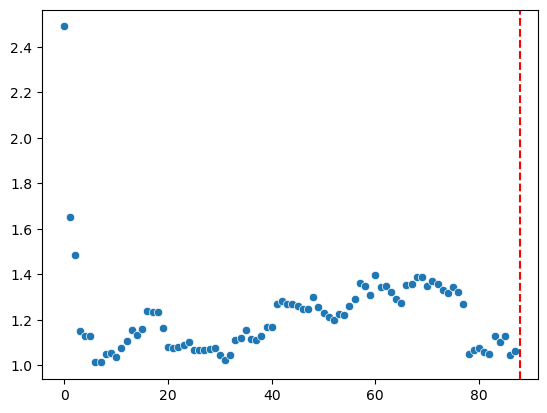

In [26]:
best_mse = np.argmin(results)
sns.scatterplot(results)
plt.axvline(x=best_mse, color='red', linestyle='--')

In [27]:
pca = PCA(n_components = best_mse)
intermediary_pipe = make_pipeline(scaler, interact, pca, ols)
pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
pipe.fit(X_train, y_train)
residuals = (y_train - pipe.predict(X_train))

<Axes: ylabel='crim'>

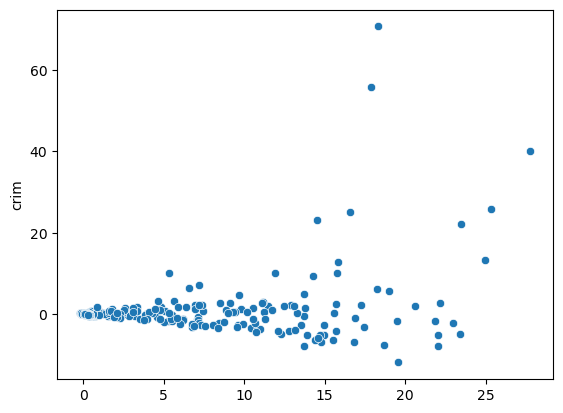

In [28]:
sns.scatterplot(x=pipe.predict(X_train), y=residuals)
# sns.scatterplot(y_train)

In [29]:
%%capture
### Let's transform the predictor for them to be more gaussian as well

results = {}
interact = PolynomialFeatures(degree=2, interaction_only=True)
power = PowerTransformer(method="yeo-johnson")
for name, model in models.items():
    pipe = make_pipeline(power, interact, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [30]:
results

{'ridge': 2.1936542102240746,
 'lasso': 1.782036242562178,
 'ols': 2.921273725655411,
 'elasticnet': 1.821858657611428,
 'gamma': 0.9054589212954175,
 'tweedie': 1.9065563397060394}

<Axes: ylabel='crim'>

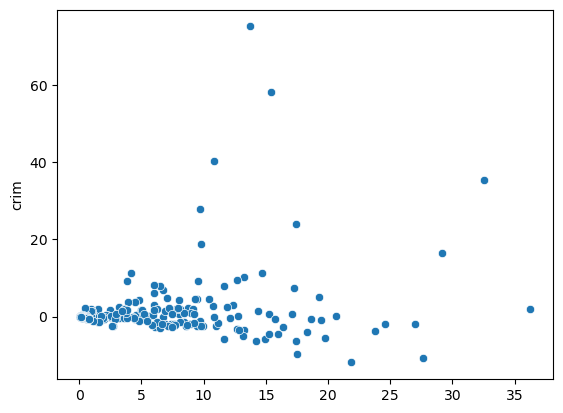

In [31]:
results = {}
interact = PolynomialFeatures(degree=2, interaction_only=True)
power = PowerTransformer(method="yeo-johnson")
pipe = make_pipeline(power, interact, gamma)
pipe.fit(X_train, y_train)
residuals = y_train - pipe.predict(X_train)
sns.scatterplot(x=pipe.predict(X_train), y=residuals)

In [32]:
%%capture
### Let's transform the predictor with their log

results = {}
interact = PolynomialFeatures(degree=2, interaction_only=True)
log_transform = FunctionTransformer(np.log1p)
for name, model in models.items():
    pipe = make_pipeline(log_transform, interact, model)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [33]:
results

{'ridge': 2.404526714945562,
 'lasso': 2.01487512634953,
 'ols': 2.9923990156249998,
 'elasticnet': 1.922415883949928,
 'gamma': 1.1646459747561757,
 'tweedie': 2.1941078786820563}

In [34]:
pipe = make_pipeline(log_transform, interact, gamma)
pipe.fit(X_train, y_train)
gamma_res = y_train - pipe.predict(X_train)
#sns.scatterplot(x=pipe.predict(X_train), y=residuals)

In [35]:
%%capture
### Let's transform the predictor with their log

results = {}
interact = PolynomialFeatures(degree=2)
log_transform = FunctionTransformer(np.log1p)
for name, model in models.items():
    intermediary_pipe = make_pipeline(log_transform, interact, model)
    pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
    results[name] = -cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()
print("Various Linear model to predict log of crim Cross_Val MSE:")

In [36]:
results

{'ridge': 1.1987378334088195,
 'lasso': 0.8544096576166323,
 'ols': 1.1595061937234887,
 'elasticnet': 0.8277988260444251,
 'gamma': 1.2565300469098768,
 'tweedie': 0.8570125245427986}

<Axes: ylabel='crim'>

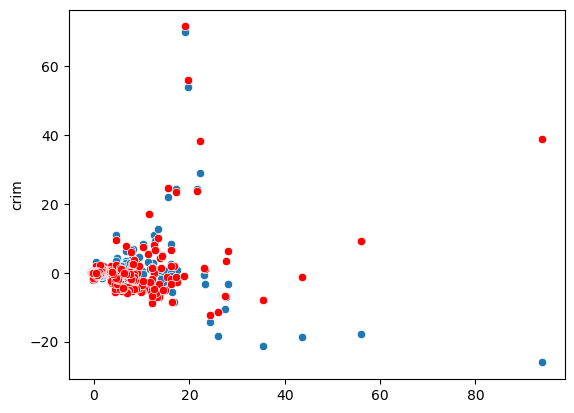

In [37]:
intermediary_pipe = make_pipeline(log_transform, interact, model)
pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
pipe.fit(X_train, y_train)
ols_res = residuals = y_train - pipe.predict(X_train)
sns.scatterplot(x=pipe.predict(X_train), y=residuals)

In [61]:
%%capture
parameters ={'regressor__tweedieregressor__power' : [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0], 'regressor__tweedieregressor__alpha': np.linspace(0, 10, 50)}
model = TweedieRegressor(max_iter=10000)
interact = PolynomialFeatures(degree=2)
intermediary_pipe = make_pipeline(log_transform, interact, model)
pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)
clf = GridSearchCV(pipe, parameters, cv=10, verbose=2, scoring='neg_median_absolute_error')
clf.fit(X_train,y_train)

In [62]:
clf.best_params_

{'regressor__tweedieregressor__alpha': 4.081632653061225,
 'regressor__tweedieregressor__power': 1.75}

In [63]:
model = TweedieRegressor(alpha = 4.081632653061225, power = 1.75, max_iter=10000)
interact = PolynomialFeatures(degree=2)
intermediary_pipe = make_pipeline(log_transform, interact, model)
pipe = TransformedTargetRegressor(regressor=intermediary_pipe,func=np.log1p, inverse_func=np.expm1)

In [70]:
model = pipe.fit(X_train,y_train)
-cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_median_absolute_error').mean()

0.7541092944675661

<Axes: ylabel='crim'>

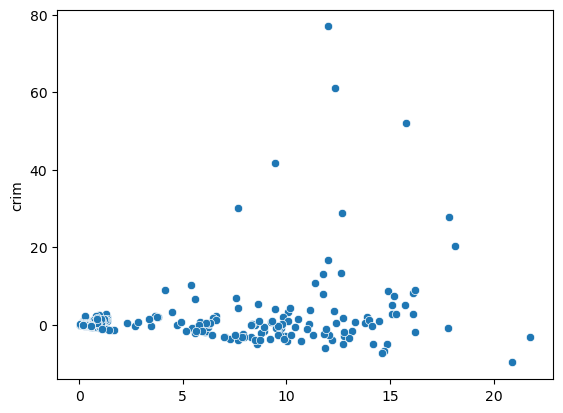

In [71]:
residuals = y_train - pipe.predict(X_train)
sns.scatterplot(x=pipe.predict(X_train), y=residuals)

<Axes: >

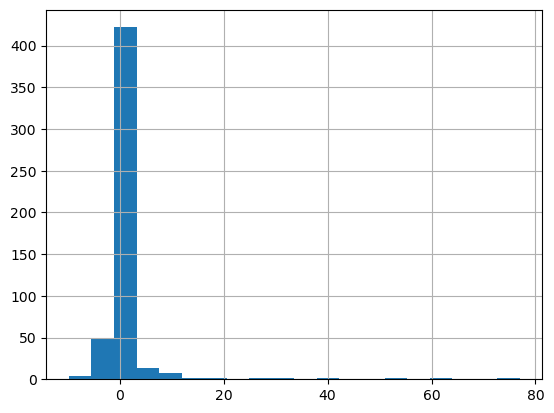

In [76]:
residuals.hist(bins=20)